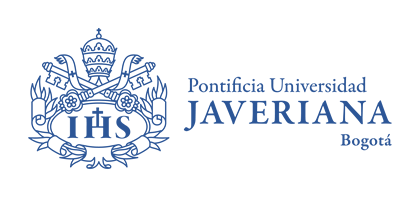

# Proyecto de grado - Training modelo CNN para clasificación de presencia o ausencia de ruido

- Juan Sebastián Vargas Torres
- Jessica Tatiana Naizaque Guevara
- Estefanía Bermúdez Arroyo

## Imports

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv3D, BatchNormalization, LeakyReLU, Conv3DTranspose, Activation, Flatten,Dense,MaxPooling3D,Conv2D
import numpy as np
import nibabel as nib
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc,accuracy_score
)

In [ ]:
print(tf.keras.__version__)

2.12.0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones Útiles

In [ ]:
def print_stats(y_test, y_pred):
  """
  Prints the accuracy, precision, recall and F1-score stats for the given labels

  Args:
  - y_test, true labels
  - y_pred, predicted labels
  """
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred, average="weighted"))
  print("Recall:", recall_score(y_test, y_pred,average="weighted"))
  print("F1-Score:", f1_score(y_test, y_pred,average="weighted"))

In [ ]:
def print_confusion_matrix(y_test, y_pred):
  """
  Draws a confusion matrix for the given labels

  Args:
  - y_test, true labels
  - y_pred, predicted labels
  """
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
  plt.title('Confusion Matrix')
  plt.xlabel('true label')
  plt.ylabel('predicted label')

In [ ]:
def print_train_val_graph(model):
  """
  Draws a confusion matrix for the given labels

  Args:
  - y_test, true labels
  - y_pred, predicted labels
  """
  plt.plot(model.loss_curve_)
  plt.plot( 1 - np.array(model.validation_scores_))
  plt.legend(['Train','Validation'])

## Reading Data

In [ ]:
MAIN_PATH="/content/drive/MyDrive/trabajoGrado/Data_2/ResultedData"

In [ ]:
X_train,Y_train= np.load(f'{MAIN_PATH}/X_train.npy'),np.load(f'{MAIN_PATH}/Y_train.npy')
X_val,Y_val= np.load(f'{MAIN_PATH}/X_val.npy'),np.load(f'{MAIN_PATH}/Y_val.npy')
X_test,Y_test= np.load(f'{MAIN_PATH}/X_test.npy'),np.load(f'{MAIN_PATH}/Y_test.npy')

In [ ]:
X_train.shape

(2656, 256, 256, 6)

In [ ]:
Y_train.shape

(2656,)

In [ ]:
X_val.shape

(332, 256, 256, 6)

In [ ]:
Y_val.shape

(332,)

## Creating the model

In [ ]:
input_shape = (256, 256,6,1)
generator_net = Sequential()


generator_net.add(Conv3D(32, kernel_size=(3,3,3), padding='same',input_shape=input_shape))

generator_net.add(LeakyReLU(alpha=0.2))

generator_net.add(MaxPooling3D((3,3,3)))

generator_net.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))

generator_net.add(LeakyReLU(alpha=0.2))


generator_net.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))

generator_net.add(LeakyReLU(alpha=0.2))


generator_net.add(Conv3D(256, kernel_size=(3,3,3), padding='same'))

generator_net.add(LeakyReLU(alpha=0.2))


generator_net.add(MaxPooling3D((2,2,2)))


generator_net.add(Flatten())

generator_net.add(Dense(16,activation='relu'))
generator_net.add(BatchNormalization())

generator_net.add(Dense(8,activation='relu'))
generator_net.add(BatchNormalization())

generator_net.add(Dense(1,activation="relu"))

# Compile the model
generator_net.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0012))


In [ ]:
generator_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 256, 256, 6, 32)   896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 6, 32)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 85, 85, 2, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 85, 85, 2, 64)     55360     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 85, 85, 2, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 85, 85, 2, 128)    221312    
                                                        

In [ ]:
predictions=np.array([0,1,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

In [ ]:
predicted_label=0

In [ ]:
prediction_count = np.count_nonzero(predictions == predicted_label)
print(prediction_count)
confidence=prediction_count/len(predictions)
print("Confidence: ",confidence)

23
Confidence:  0.7419354838709677


## Training the model 

In [ ]:
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=8)
callback_checkpoint= ModelCheckpoint(filepath='/tmp/checkpoints',monitor='val_loss', mode='min',save_best_only=True)

In [ ]:
# Train the model
EPOCHS=60
history= generator_net.fit(X_train,Y_train, epochs=EPOCHS, validation_data=(X_val,Y_val),callbacks=[callback_early,callback_checkpoint],batch_size=16,shuffle=True)

Epoch 1/60
112/112 [==============================] - ETA: 0s - loss: 6.9366

112/112 [==============================] - 85s 608ms/step - loss: 6.9366 - val_loss: 7.7125
Epoch 2/60
112/112 [==============================] - 70s 627ms/step - loss: 6.9564 - val_loss: 7.7125
Epoch 3/60
112/112 [==============================] - ETA: 0s - loss: 2.2247

112/112 [==============================] - 75s 667ms/step - loss: 2.2247 - val_loss: 0.7247
Epoch 4/60
112/112 [==============================] - ETA: 0s - loss: 0.8281

112/112 [==============================] - 75s 671ms/step - loss: 0.8281 - val_loss: 0.6841
Epoch 5/60
112/112 [==============================] - 73s 651ms/step - loss: 1.0170 - val_loss: 0.7534
Epoch 6/60
112/112 [==============================] - 73s 649ms/step - loss: 0.6324 - val_loss: 0.6941
Epoch 7/60
112/112 [==============================] - ETA: 0s - loss: 0.5633

112/112 [==============================] - 75s 671ms/step - loss: 0.5633 - val_loss: 0.6764
Epoch 8/60
112/112 [==============================] - ETA: 0s - loss: 0.6859

112/112 [==============================] - 75s 671ms/step - loss: 0.6859 - val_loss: 0.6720
Epoch 9/60
112/112 [==============================] - 73s 653ms/step - loss: 0.6982 - val_loss: 0.6836
Epoch 10/60
112/112 [==============================] - 73s 652ms/step - loss: 0.6879 - val_loss: 0.6808
Epoch 11/60
112/112 [==============================] - 73s 651ms/step - loss: 0.8972 - val_loss: 0.7120
Epoch 12/60
112/112 [==============================] - 73s 652ms/step - loss: 0.7536 - val_loss: 0.7017
Epoch 13/60
112/112 [==============================] - ETA: 0s - loss: 0.7832

112/112 [==============================] - 75s 672ms/step - loss: 0.7832 - val_loss: 0.6671
Epoch 14/60
112/112 [==============================] - ETA: 0s - loss: 0.5860

112/112 [==============================] - 75s 670ms/step - loss: 0.5860 - val_loss: 0.6661
Epoch 15/60
112/112 [==============================] - 73s 652ms/step - loss: 0.6616 - val_loss: 0.6706
Epoch 16/60
112/112 [==============================] - ETA: 0s - loss: 0.5707

112/112 [==============================] - 75s 668ms/step - loss: 0.5707 - val_loss: 0.6485
Epoch 17/60
112/112 [==============================] - 73s 652ms/step - loss: 0.4876 - val_loss: 0.6708
Epoch 18/60
112/112 [==============================] - 73s 650ms/step - loss: 0.5035 - val_loss: 0.7044
Epoch 19/60
112/112 [==============================] - 73s 652ms/step - loss: 0.4373 - val_loss: 0.7444
Epoch 20/60
112/112 [==============================] - 73s 653ms/step - loss: 0.3917 - val_loss: 0.7459
Epoch 21/60
112/112 [==============================] - 73s 651ms/step - loss: 0.3395 - val_loss: 0.9519
Epoch 22/60
112/112 [==============================] - 73s 651ms/step - loss: 0.3520 - val_loss: 1.1462
Epoch 23/60
112/112 [==============================] - 73s 653ms/step - loss: 0.3214 - val_loss: 0.8933
Epoch 24/60
112/112 [==============================] - 73s 652ms/step - loss: 0.2601 - val_loss: 0.7406


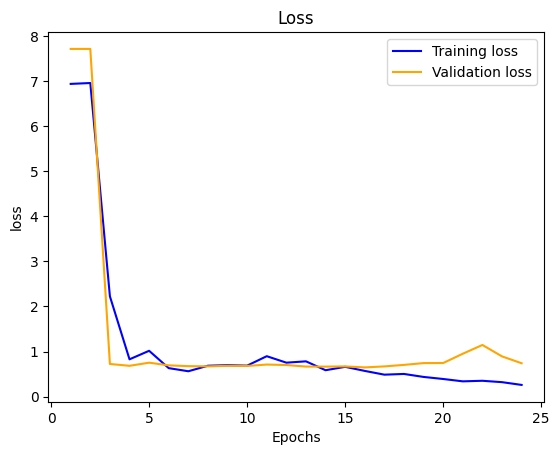

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs') 
plt.ylabel('loss')  
plt.legend()
plt.show()

In [ ]:
generator_net.save("/content/drive/MyDrive/trabajoGrado/Data_2/ResultedData/weights_2")

## Evaluating results

In [ ]:
generator_net.load_weights('/tmp/checkpoints')

In [ ]:
import shutil

# Define the source and destination folder paths
source_folder_path = "/tmp/checkpoints"
destination_folder_path = "/content/drive/MyDrive/trabajoGrado/Data_2/ResultedData/weights_final"

shutil.copytree(source_folder_path, destination_folder_path)
 

'/content/drive/MyDrive/trabajoGrado/Data_2/ResultedData/weights_final'

In [ ]:
X_test.shape

(415, 256, 256, 6)

In [ ]:
pr= generator_net.predict(X_test) #It could be achieve like this too.
#pr= generator_net.predict(np.array( [X_test[0],] ) ) ## For one prediction
#pr= generator_net.predict(test_dataset)

13/13 [==============================] - 11s 641ms/step


In [ ]:
pr.shape

(415, 1)

In [ ]:
pr[:320]

array([[5.44363678e-01],
       [5.44074297e-01],
       [5.43448925e-01],
       [5.41418672e-01],
       [5.33766687e-01],
       [5.21674275e-01],
       [5.06539404e-01],
       [4.91678059e-01],
       [4.84698355e-01],
       [4.81727123e-01],
       [4.77591455e-01],
       [4.75364089e-01],
       [4.73451972e-01],
       [4.75119352e-01],
       [4.81263399e-01],
       [4.85111833e-01],
       [4.86055076e-01],
       [4.83591676e-01],
       [4.80641186e-01],
       [4.79170322e-01],
       [4.79174733e-01],
       [4.78721261e-01],
       [4.79061663e-01],
       [4.79747891e-01],
       [4.80122983e-01],
       [4.80115235e-01],
       [4.78472531e-01],
       [4.76782143e-01],
       [4.75050628e-01],
       [4.76408601e-01],
       [4.79640186e-01],
       [4.81853426e-01],
       [4.84362781e-01],
       [4.85281527e-01],
       [4.84115541e-01],
       [4.84678149e-01],
       [4.84285057e-01],
       [4.83154774e-01],
       [4.83201623e-01],
       [4.83505964e-01],


In [ ]:
pr_int= (pr>0.5).astype(int)

In [ ]:
pr_int

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

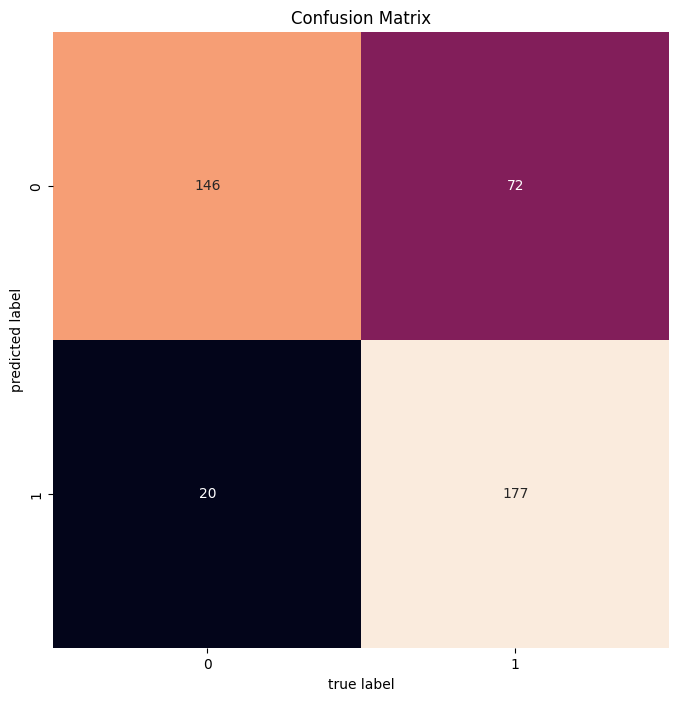

In [ ]:
plt.figure(figsize=(8,8))
print_confusion_matrix(Y_test,pr_int)

In [ ]:
print_stats(Y_test,pr_int)

Accuracy: 0.7783132530120482
Precision: 0.8069762026731244
Recall: 0.7783132530120482
F1-Score: 0.7803998505231688
